In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from bikesharing.interface.main import preprocess

In [ ]:
X, y = preprocess()
print(X.shape)
print(y.shape)

In [ ]:
X.head(5)

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,is_holiday,is_weekend
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1,0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1,0
2,0.359823,1.000000,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1,0
3,0.359823,0.987013,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1,0
4,0.359823,1.000000,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1,0


In [ ]:
y.head(5)

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = pd.concat([X, y], axis=1)
print(data.shape)
print(data.head(3))

(35040, 47)
   temperature_2m  relativehumidity_2m  apparent_temperature  windspeed_10m  \
0        0.355408             1.000000              0.342007       0.227848   
1        0.357616             0.987013              0.340149       0.245570   
2        0.359823             1.000000              0.336431       0.303797   

   precipitation  hour_sin  hour_cos  month_sin  month_cos   day_sin  ...  \
0       0.017391  0.629410  0.982963       0.75   0.933013  0.600779  ...   
1       0.008696  0.750000  0.933013       0.75   0.933013  0.600779  ...   
2       0.017391  0.853553  0.853553       0.75   0.933013  0.600779  ...   

   Schwanthalerhöhe  Sendling  Sendling-Westpark  Südgiesing  Thalkirchen  \
0               0.0       0.0                2.0         0.0          0.0   
1               0.0       2.0                0.0         0.0          0.0   
2               0.0       5.0                0.0         0.0          0.0   

   Trudering  Trudering-Riem  Untergiesing  Untergies

In [2]:
# data.to_csv('../raw_data/final_processed_xy_data.csv')
data = pd.read_csv('final_processed_xy_data.csv', index_col=False)
data = data.drop(columns= 'Unnamed: 0')
print(data.shape)
data.head(2)

(35040, 47)


,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.75000,0.933013,0.75,0.933013,0.600779,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Train-Test split

In [3]:
## Functions for train-test split

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Sequence

def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

def train_test_indices(fold:pd.DataFrame,
                    train_test_ratio: float,
                    input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train contains all the timesteps until round(train_test_ratio * len(fold))
    - df_test contains all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """

    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [49]:
data.columns

Index(['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'is_holiday', 'is_weekend',
       'Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')

In [4]:
X = data[['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'is_holiday', 'is_weekend']]
y = data[['Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach']]

In [5]:
districts = y.columns
print(len(districts))
districts

34


Index(['Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')

In [6]:
FOLD_LENGTH = 17520 # 2 years
FOLD_STRIDE = 2184 # 3 months
TRAIN_TEST_RATIO = 0.8
INPUT_LENGTH = 336 # 24 h * 14 d
OUTPUT_LENGTH = 24

folds = get_folds(data, FOLD_LENGTH, FOLD_STRIDE)
print('Number of folds:', len(folds))

Number of folds: 9


In [7]:
# First fold
(fold_train, fold_test) = train_test_split(folds[0], TRAIN_TEST_RATIO, INPUT_LENGTH)
print(fold_train.shape)
print(fold_test.shape)

(14016, 47)
(3840, 47)


## Prediction for All Districts

In [8]:
TARGET = districts
N_TARGETS = len(districts)
N_FEATURES = len(X.columns)
print('N_FEATURES:', N_FEATURES)

N_FEATURES: 13


In [9]:
## Functions for train-test split
def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]

    return (X_i, y_i)

def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> Tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

In [10]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [11]:
print(f'X_train_i: {X_train_i.shape}, y_train: {y_train_i.shape}')
print(f'X_test_i: {X_test_i.shape}, y_test: {y_test_i.shape}')

X_train_i: (336, 47), y_train: (24, 34)
X_test_i: (336, 47), y_test: (24, 34)


In [ ]:
# N_TRAIN = 8000 # number_of_sequences_train
# N_TEST =  2000 # number_of_sequences_test

# X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
# X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

# print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
# print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

In [ ]:
# X_train[0,0,:]

In [ ]:
# y_train[0,0,:]

## Prediction for Maxvorstadt

In [12]:
# Select a single target district
TARGET = 'Maxvorstadt'
N_TARGETS = len(districts)

In [15]:
# Prepare data for the selected target
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

# Shape of the data
print(f'X_train_i: {X_train_i.shape}, y_train_i: {y_train_i.shape}')
print(f'X_test_i: {X_test_i.shape}, y_test_i: {y_test_i.shape}')

X_train_i: (336, 47), y_train_i: (24,)
X_test_i: (336, 47), y_test_i: (24,)


In [14]:
# Reshape array to shape (24,1)
y_test_i = np.expand_dims(y_test_i, axis=1)
print(y_test_i.shape)

(24, 1)


In [36]:
N_TRAIN = 8000 # number_of_sequences_train
N_TEST =  2000 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (8000, 336, 47), y_train: (8000, 24)
X_test: (2000, 336, 47), y_test: (2000, 24)


In [ ]:
# Reshape array to shape (24,1)
# y_test = np.expand_dims(y_test, axis=1)
# print(y_test.shape)

In [37]:
y_train = np.reshape(y_train, (8000, 24, 1))
y_test = np.reshape(y_test, (2000, 24, 1))

print(f'y_train_rnn: {y_train.shape}')
print(f'y_test_rnn: {y_test.shape}')


y_train_rnn: (8000, 24, 1)
y_test_rnn: (2000, 24, 1)


## RNN Model

In [43]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow import keras
from keras.callbacks import EarlyStopping

def init_model(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 10,
                        callbacks = [es],
                        verbose = verbose)

    return model, history


In [44]:
# 1 - Initialising the RNN model
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
model, history = fit_model(model)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 47)         95        
 ion)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 64)                28672     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
Total params: 30,327
Trainable params: 30,232
Non-trainable params: 95
_________________________________________________________________
Epoch 1/10
175/175 [==============================] - 35s 187ms/step - loss: 111.1907 - mae: 7.5023 - val_loss: 88.9141 - val_mae: 6.6649
Epoch 2/10
175/175 [==============================] - 38s 214ms/step - loss: 79.8036 - mae: 6.1059 - val_los

In [46]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

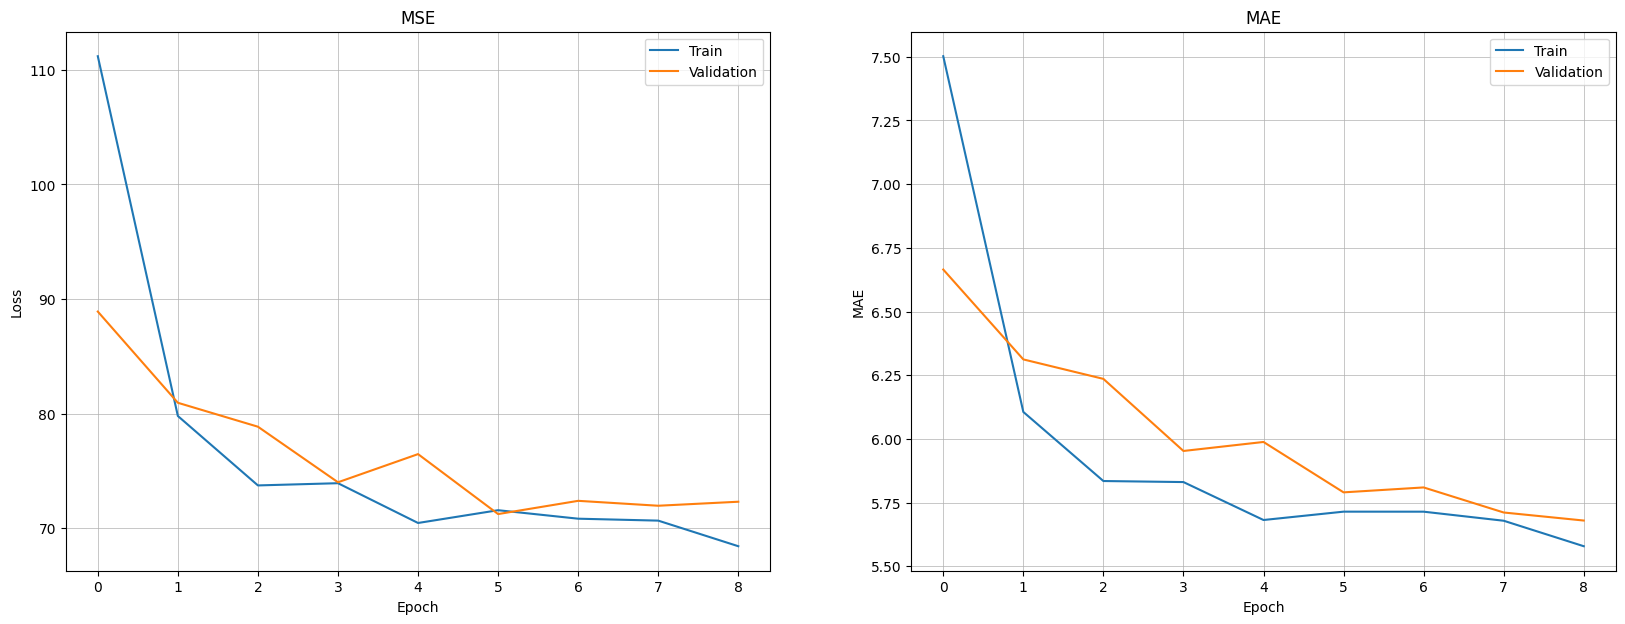

In [47]:
plot_history(history);


## Prediction for Lochhausen
---



In [48]:
# Select a single target district
TARGET = 'Lochhausen'
N_TARGETS = len(districts)

In [49]:
N_TRAIN = 8000 # number_of_sequences_train
N_TEST =  2000 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (8000, 336, 47), y_train: (8000, 24)
X_test: (2000, 336, 47), y_test: (2000, 24)


In [50]:
y_train = np.reshape(y_train, (8000, 24, 1))
y_test = np.reshape(y_test, (2000, 24, 1))

print(f'y_train_rnn: {y_train.shape}')
print(f'y_test_rnn: {y_test.shape}')

y_train_rnn: (8000, 24, 1)
y_test_rnn: (2000, 24, 1)


In [51]:
# 1 - Initialising the RNN model
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
model, history = fit_model(model)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 47)         95        
 ion)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 64)                28672     
                                                                 
 dense_11 (Dense)            (None, 24)                1560      
                                                                 
Total params: 30,327
Trainable params: 30,232
Non-trainable params: 95
_________________________________________________________________
Epoch 1/10
175/175 [==============================] - 36s 189ms/step - loss: 3.0537 - mae: 0.0463 - val_loss: 1.6685 - val_mae: 0.0433
Epoch 2/10
175/175 [==============================] - 33s 186ms/step - loss: 1.6377 - mae: 0.0406 - val_loss: 1

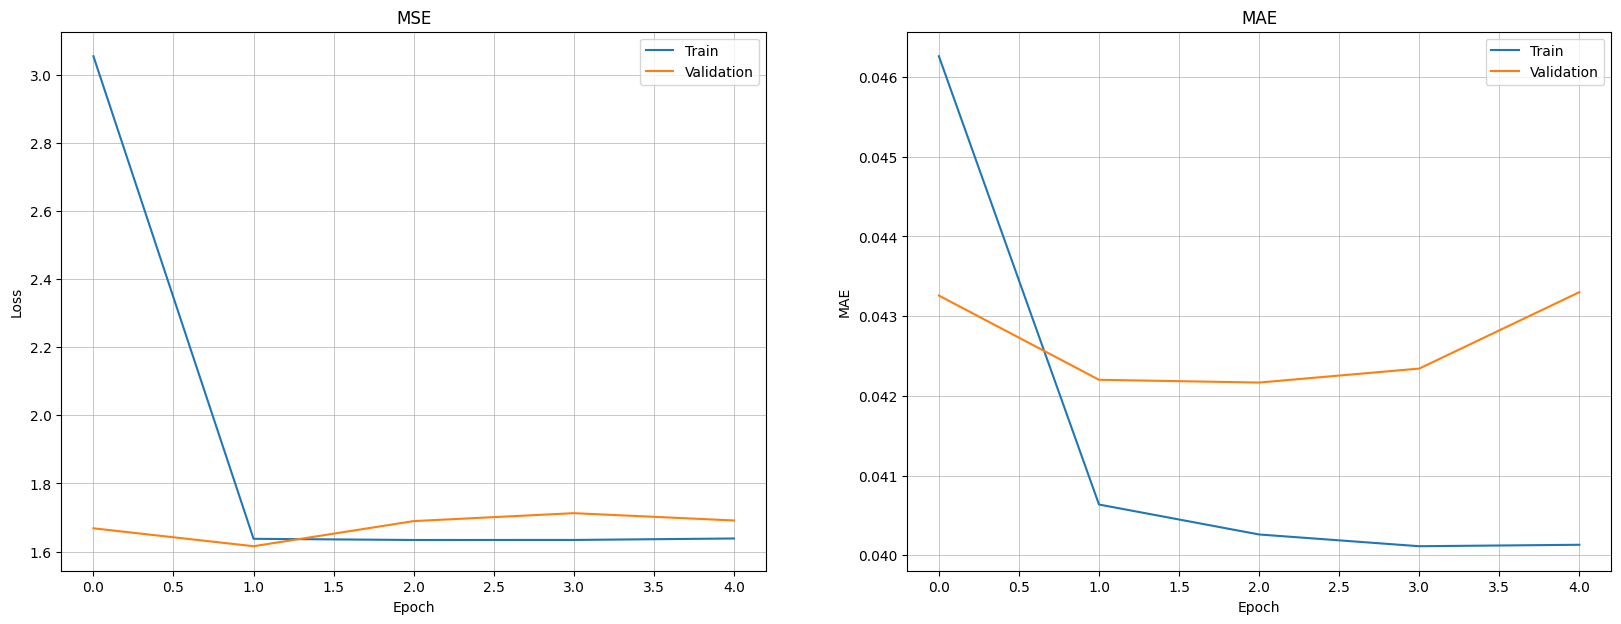

In [52]:
plot_history(history);

## Weather Data Exploration

In [5]:
import sys
sys.path.append('../')

from bikesharing.params import *
from bikesharing.ml_logic.data import get_weather_data

In [6]:
weather_data_df = get_weather_data(cache_path=Path(f'{LOCAL_DATA_PATH}/raw/histotical_weather_data_{START_YEAR}_to_{END_YEAR}.csv'))
weather_data_df.to_csv('../raw_data/histotical_weather_data_{START_YEAR}_to_{END_YEAR}.csv')
print(weather_data_df.shape)
print(weather_data_df.head(3))


Load weather_data from local CSV...
✅ Data loaded, with shape (35064, 6)
(35064, 6)
               time  temperature_2m  relativehumidity_2m  \
0  2019-01-01T00:00             3.3                  100   
1  2019-01-01T01:00             3.4                   99   
2  2019-01-01T02:00             3.5                  100   

   apparent_temperature  windspeed_10m  precipitation  
0                   0.5            9.0            0.2  
1                   0.4            9.7            0.1  
2                   0.2           12.0            0.2  


In [8]:
# Read weather data
weather_data = pd.read_csv('../raw_data/histotical_weather_data_{START_YEAR}_to_{END_YEAR}.csv', index_col=False)
weather_data = weather_data.drop(columns= 'Unnamed: 0')
print(weather_data.shape)
weather_data.head(2)

(35064, 6)


,time,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
0,2019-01-01T00:00,3.3,100,0.5,9.0,0.2
1,2019-01-01T01:00,3.4,99,0.4,9.7,0.1
